<a href="https://colab.research.google.com/github/tranlg99/L4_project/blob/main/src/colab_notebooks/double_input_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two input model
Investigating two input model and its performance when fine-tuning, first layer, first layer + second layer, all layers along with the last layer.

Using SGD optimizer with lr=? and 30K epochs.

# Imports

In [1]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

import torchvision
import numpy as np
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import time
import copy
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import sys
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor, Normalize

Mounted at /content/drive


# Helper functions

In [2]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def meshgrid2d(B, Y, X, stack=False, device='cuda'):
    # returns a meshgrid sized B x Y x X

    grid_y = torch.linspace(0.0, Y-1, Y, device=torch.device(device))
    grid_y = torch.reshape(grid_y, [1, Y, 1])
    grid_y = grid_y.repeat(B, 1, X)

    grid_x = torch.linspace(0.0, X-1, X, device=torch.device(device))
    grid_x = torch.reshape(grid_x, [1, 1, X])
    grid_x = grid_x.repeat(B, Y, 1)

    if stack:
        # note we stack in xy order
        # (see https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample)
        grid = torch.stack([grid_x, grid_y], dim=-1)
        return grid
    else:
        return grid_y, grid_x

def get_grid(N, B, H, W, normalise=False):
  N_ = np.sqrt(N).round().astype(np.int32)
  grid_y, grid_x = meshgrid2d(B, N_, N_, stack=False, device='cuda')
  grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
  grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)

  if normalise:
    # normalise to values of range [-1, 1] - x = -1, y = -1 is the left-top pixel
    grid_x = (grid_x - W) / W 
    grid_y = (grid_y - H) / H

  xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
  xy = xy.view(B, N_, N_, 2)

  return xy

import matplotlib.pyplot as plt

def show_predictions(pred_coords, pred_vis, true_coords, true_vis, zeroed=False):
  pred_coords = pred_coords.cpu().detach().numpy()
  pred_vis = pred_vis.cpu().detach().numpy()
  true_coords = true_coords.cpu().numpy()
  true_vis = true_vis.cpu().numpy()

  pred_vis = pred_vis <= 0
  true_vis = true_vis <= 0

  print(np.count_nonzero(true_vis))
  print(np.count_nonzero(pred_vis))

  if zeroed:
    true_coords[ :, 0] = np.where(true_vis, 0, true_coords[ :, 0])
    true_coords[ :, 1] = np.where(true_vis, 0, true_coords[ :, 1])
    pred_coords[ :, 0] = np.where(pred_vis, 0, pred_coords[ :, 0])
    pred_coords[ :, 1] = np.where(pred_vis, 0, pred_coords[ :, 1])
    pred_vis = true_vis
  

  plt.scatter(true_coords[:, 0], true_coords[:, 1], s=0.5, marker='.', c=true_vis, cmap=plt.cm.coolwarm)
  plt.ylim(max(plt.ylim()), min(plt.ylim()))
  plt.title('True Coords')
  plt.pause(0.001)  # pause a bit so that plots are updated
  
  pred_x = pred_coords[:, 0]
  pred_y = pred_coords[:, 1]
  plt.scatter(pred_x, pred_y, s=0.5, marker='.', c=pred_vis, cmap=plt.cm.coolwarm)
  plt.ylim(max(plt.ylim()), min(plt.ylim()))
  plt.title('Predicted Coords')
  plt.pause(0.001)  # pause a bit so that plots are updated

def plot_learning_curve(losses, vis_losses, coords_losses):
  plt.plot(np.arange(len(losses)), losses, label = "total loss")
  plt.plot(np.arange(len(losses)), vis_losses, label = "vis loss")
  plt.plot(np.arange(len(losses)), coords_losses, label = "coords loss")
  plt.legend()
  plt.show()


def split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed):
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
  validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

  return train_loader, validation_loader

# Loading dataset

In [3]:
# Load dataset

TRAIN_DATA = "training_data_1_2frames2023-02-03"
!unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([
                                               ToTensor(),
                                               Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                        ]))
print(len(dataset))

Archive:  /content/drive/MyDrive/training_data_1_2frames2023-02-03.zip
   creating: training_data_1_2frames2023-02-03/vis/
  inflating: training_data_1_2frames2023-02-03/vis/-CR4xjdQbkc_792.npy  
   creating: training_data_1_2frames2023-02-03/frame0/
  inflating: training_data_1_2frames2023-02-03/frame0/-CR4xjdQbkc_792.npy  
 extracting: training_data_1_2frames2023-02-03/sample_ids.txt  
   creating: training_data_1_2frames2023-02-03/frame7/
  inflating: training_data_1_2frames2023-02-03/frame7/-CR4xjdQbkc_792.npy  
   creating: training_data_1_2frames2023-02-03/frame3/
  inflating: training_data_1_2frames2023-02-03/frame3/-CR4xjdQbkc_792.npy  
   creating: training_data_1_2frames2023-02-03/coords/
  inflating: training_data_1_2frames2023-02-03/coords/-CR4xjdQbkc_792.npy  
   creating: training_data_1_2frames2023-02-03/frame1/
  inflating: training_data_1_2frames2023-02-03/frame1/-CR4xjdQbkc_792.npy  
1


# Prediction Model

In [38]:
def initialise_model(device, to_learn=[]):
  # Initialize model with the best available weights
  # create an instance of (e.g.) torchvision.models.segmentation.fcn_resnet50
  # and tell it to load pretrained weights
  weights = FCN_ResNet50_Weights.DEFAULT
  modified_model = fcn_resnet50(weights=weights)
  # print(modified_model)

  # Get first layer weights and double
  model_weights = {k: (v, v.dtype, v.shape) for k, v in modified_model.state_dict().items()}
  first_layer_weights = model_weights['backbone.conv1.weight'][0]
  # print('backbone.conv1.weight: {} {}'.format(model_weights['backbone.conv1.weight'][1], model_weights['backbone.conv1.weight'][2]))
  doubled_weights = first_layer_weights.repeat(1, 2, 1, 1)


  # modify the model by doubling input channel from 3 to 6 
  modified_model.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  # copy the doubled weights into first layer
  with torch.no_grad():
      modified_model.backbone.conv1.weight = torch.nn.Parameter(doubled_weights)

  # removing final layer and replacing with a 2D vector output at each pixel and visibility (instead of 20 class logits)
  # instead of torch.Size([1, 21, 120, 240]) -> torch.Size([1, 3, 120, 240])
  modified_model.classifier[3] = nn.Sequential()
  modified_model.classifier[4] = nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))

  # choose which params to tune
  if "all" not in to_learn:
    for name, param in modified_model.named_parameters():
      if name not in to_learn:
        param.requires_grad = False

  # model to train() and load onto computation devicce
  modified_model.to(device)
  # print(modified_model)

  return modified_model

In [37]:
# set computation device
device = torch.device('cuda')

# initialise model
# possible params to_learn=[]:
#   'backbone.conv1.weight' - first layer
#   'backbone.layer1.0.conv1.weight' - second layer
#   'classifier.4.weight'
#   'classifier.4.bias'
#   'all' - all layers
modified_model = initialise_model(device, to_learn=['backbone.conv1.weight', 'backbone.layer1.0.conv1.weight', 'classifier.4.weight', 'classifier.4.bias'])

print('Params to learn:')
params_to_update = modified_model.parameters()
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

Params to learn:
backbone.conv1.weight
backbone.layer1.0.conv1.weight
classifier.4.weight
classifier.4.bias


## Train function

In [26]:
def train_model(model, dataloaders, criterion, vis_criterion, optimizer, num_epochs=25, verbose=False, mask=True):
  model.to(device)
  since = time.time()

  val_loss_history = []
  train_loss_history = []
  vis_loss_history = []
  coords_loss_history = []

  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(0,num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_vis_loss = 0.0
            running_coords_loss = 0.0
            total_samples=0

            # Iterate over data.
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
              batch_size = len(sample_batched['id'])
              total_samples+=batch_size

              input1 = sample_batched['image0']
              input2 = sample_batched['image3']
              inputs = torch.cat((input1, input2), dim=1) # concatenate tensors on C dim
              # print(inputs.size())
              coords = sample_batched['coords']
              vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)
              # vis = sample_batched['vis']

              inputs = inputs.to(device).float() #torch.Size([B, 3, 120, 240])
              coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
              vis = vis.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward and track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
                    outputs = outputs['out']

                    # TO DO: ABSTRACT THIS
                    # take the values of outputs from the NxN grid points
                    grid = get_grid(coords.shape[2], batch_size, outputs.shape[2], outputs.shape[3], normalise=True) # ([B, H(64), W(64), 2])
                    outputs = torch.nn.functional.grid_sample(outputs, grid) # torch.size([B,2,H,W])

                    # reshape to match target shape
                    outputs = torch.permute(outputs, (0, 2, 3, 1)) # torch.Size([B, H, W, 2])

                    # get vis predictions
                    outputs_coords = outputs[:, :, :, :2]
                    outputs_vis = outputs[:, : , :, -1] # changing to tensor with 0s and 1s??
                    outputs_vis = outputs_vis.view(batch_size,1,-1) # torch.Size([B, 1, 64*64])

                    ## coordinates = predicted displacement + grid points in (B, 360, 640, 2)
                    original_points = get_grid(coords.shape[2], batch_size, 360, 640)
                    outputs_coords = original_points + outputs_coords
                    outputs_coords = outputs_coords.view(batch_size,1,-1,2) # torch.Size([B, 1, 64*64, 2])

                    # take points that are not visible from vis ground truth data
                    point_visiblity = vis > 0 # Boolean array with True if visible

                    # zero out those in both outputs_coords and coords
                    # so they dont contribute to coords_loss
                    outputs_coords_zeroed = torch.zeros_like(outputs_coords)
                    coords_zeroed = torch.zeros_like(coords)
                    outputs_coords_zeroed[:, :, :, 0] = torch.where(point_visiblity, outputs_coords[:, :, :, 0], 0)
                    outputs_coords_zeroed[:, :, :, 1] = torch.where(point_visiblity, outputs_coords[:, :, :, 1], 0)
                    coords_zeroed[:, :, :, 0] = torch.where(point_visiblity, coords[:, :, :, 0], 0)
                    coords_zeroed[:, :, :, 1] = torch.where(point_visiblity, coords[:, :, :, 1], 0)

                    sigmoid = nn.Sigmoid()
                    vis_loss = (vis_criterion(sigmoid(outputs_vis), vis))/ 0.7
                    if mask:
                      coords_loss = (criterion(outputs_coords_zeroed, coords_zeroed))/20
                    else:
                      coords_loss = (criterion(outputs_coords, coords))/20
                    loss = coords_loss + vis_loss
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_vis_loss += vis_loss.item() * inputs.size(0)
                    running_coords_loss += coords_loss.item() * inputs.size(0)

            if phase == "train" and verbose:
              epoch_loss = running_loss / total_samples
              train_loss_history.append(epoch_loss)
              vis_loss_history.append(running_vis_loss/total_samples)
              coords_loss_history.append(running_coords_loss/total_samples)

              report_frequency = num_epochs//10
              if epoch%report_frequency==0 or epoch==num_epochs-1:
                print('-' * 10)
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('-' * 10)

                print('{} Loss: {:.4f}'.format(phase, epoch_loss))
                print('{:.4f} coords loss, {:.4f} vis loss'.format(coords_loss, vis_loss))
                if epoch != 0:
                  plot_learning_curve(train_loss_history[-report_frequency:], vis_loss_history[-report_frequency:], coords_loss_history[-report_frequency:])

                if batch_size==1:
                  show_predictions(outputs_coords.squeeze(), outputs_vis.squeeze(), coords.squeeze(), vis.squeeze())


            # deep copy the model
            if epoch == 0:
                best_loss = epoch_loss
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Train loss: {:4f}\n'.format(epoch_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
  plot_learning_curve(train_loss_history, vis_loss_history, coords_loss_history)
  show_predictions(outputs_coords.squeeze(), outputs_vis.squeeze(), coords.squeeze(), vis.squeeze(), zeroed=True)
  return model, val_loss_history


## Double check copying of weights

take old model, and new model and run for results

# Fine-tuning first and last layer

backbone.conv1.weight: torch.float32 torch.Size([64, 3, 7, 7])
----------
Epoch 0/29999
----------
train Loss: 2.6061
1.5433 coords loss, 1.0629 vis loss
203
3694


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


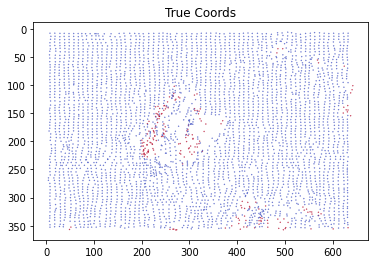

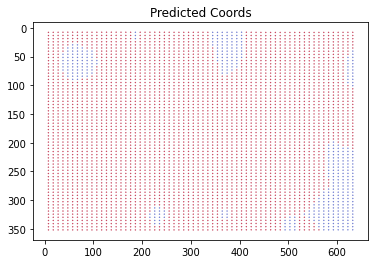

KeyboardInterrupt: ignored

In [28]:
# set computation device
device = torch.device('cuda')

# initialise model
modified_model = initialise_model(device, to_learn=['backbone.conv1.weight', 'classifier.4.weight', 'classifier.4.bias'])

# see what parameters will be tuned
params_to_update = modified_model.parameters()

# print('Params to learn:')
# for name, param in modified_model.named_parameters():
#   if param.requires_grad:
#       print(name)

# Define parameters
validation_split = .0
shuffle_dataset = True
random_seed = 42
batch_size = len(dataset)
num_epochs = 30_000

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
my_optimizer = optim.SGD(params_to_update, lr=0.101, momentum=0.9)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# Train and evaluate
modified_model, hist = train_model(modified_model,
                                   dataloaders_dict,
                                   my_criterion,
                                   my_vis_criterion,
                                   my_optimizer,
                                   num_epochs=num_epochs,
                                   verbose=True,
                                   mask=False)

# Fine-tuning last layer only

In [36]:
# set computation device
device = torch.device('cuda')

# initialise model
modified_model = initialise_model(device, to_learn=['classifier.4.weight', 'classifier.4.bias'])

# parameters to tune
params_to_update = modified_model.parameters()

print('Params to learn:')
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

# Fine-tuning first layer, second layer and last layer


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


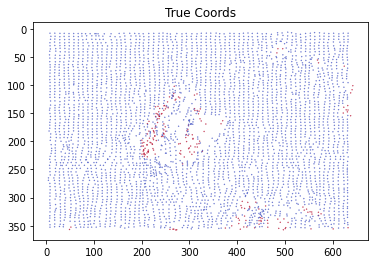

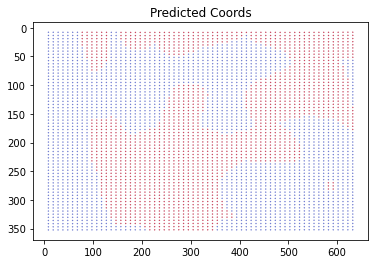

----------
Epoch 3000/29999
----------
train Loss: 0.3958
0.2801 coords loss, 0.1158 vis loss


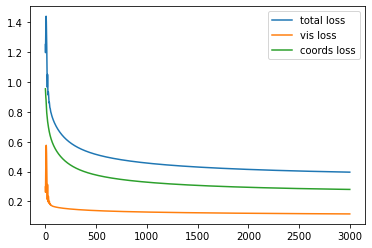

203
102


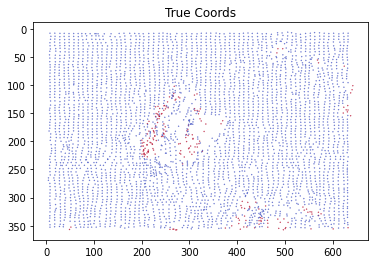

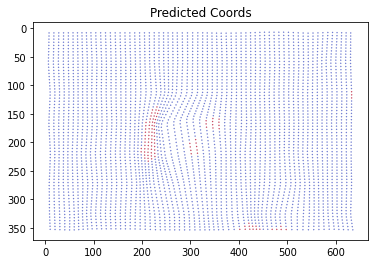

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 6000/29999
----------
train Loss: 0.3752
0.2655 coords loss, 0.1097 vis loss


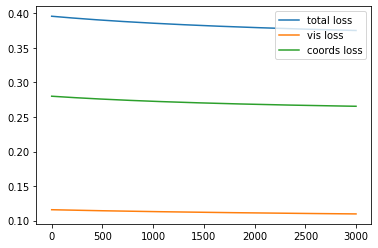

203
111


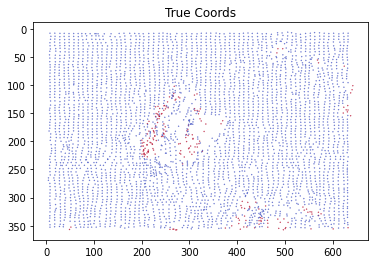

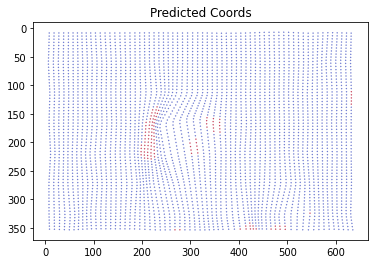

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 9000/29999
----------
train Loss: 0.3679
0.2610 coords loss, 0.1069 vis loss


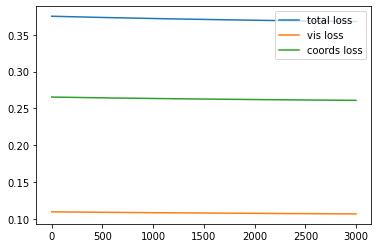

203
112


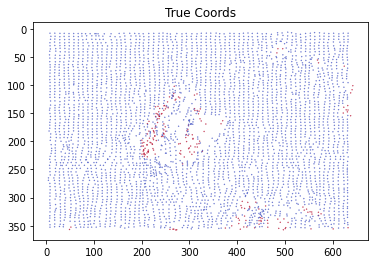

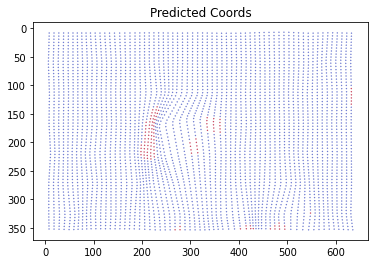

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 12000/29999
----------
train Loss: 0.3642
0.2589 coords loss, 0.1052 vis loss


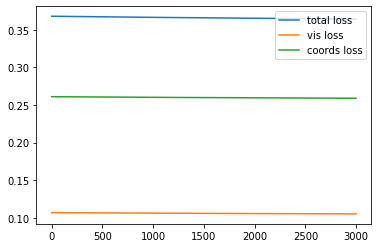

203
124


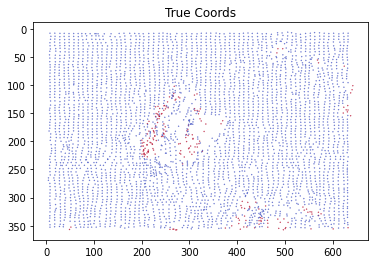

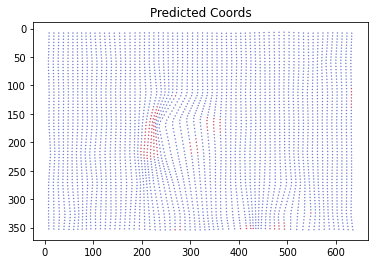

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 15000/29999
----------
train Loss: 0.3619
0.2578 coords loss, 0.1041 vis loss


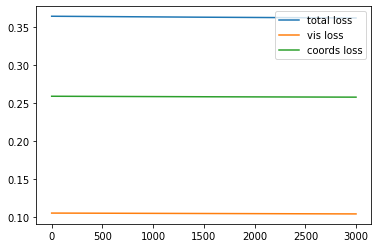

203
128


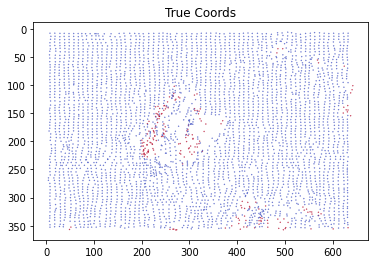

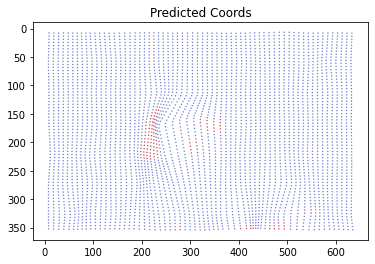

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 18000/29999
----------
train Loss: 0.3603
0.2570 coords loss, 0.1033 vis loss


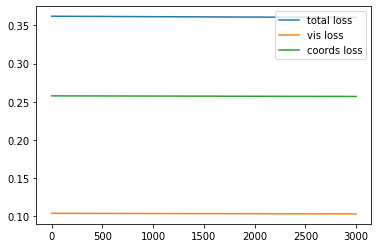

203
130


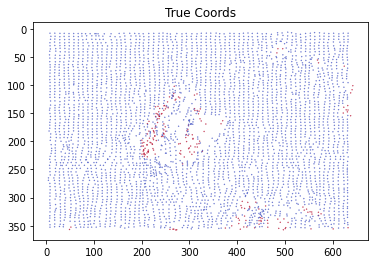

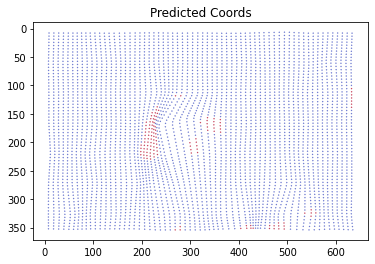

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 21000/29999
----------
train Loss: 0.3592
0.2564 coords loss, 0.1027 vis loss


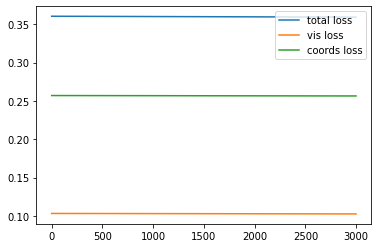

203
132


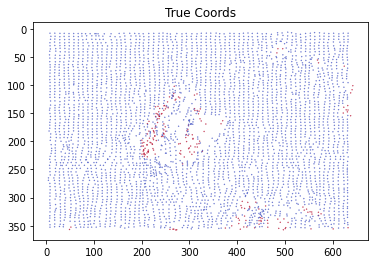

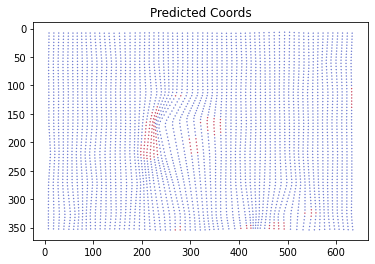

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 24000/29999
----------
train Loss: 0.3583
0.2560 coords loss, 0.1022 vis loss


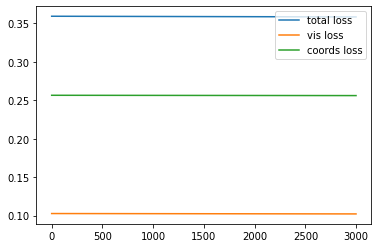

203
134


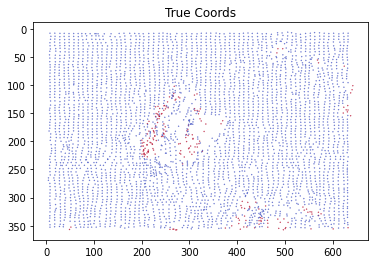

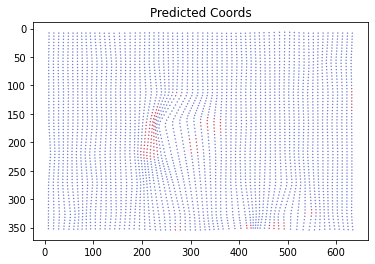

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 27000/29999
----------
train Loss: 0.3576
0.2557 coords loss, 0.1019 vis loss


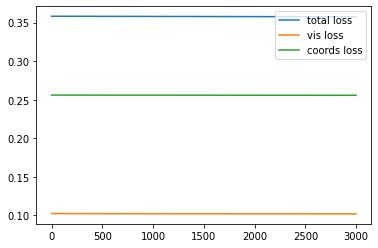

203
136


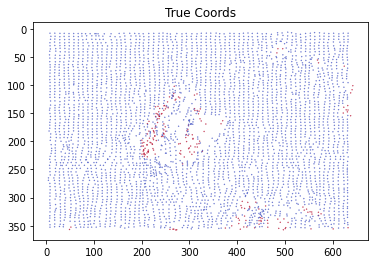

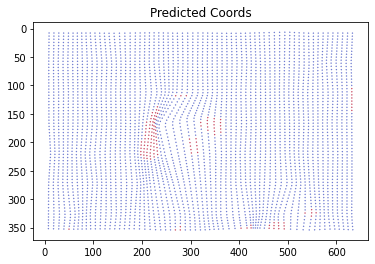

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


----------
Epoch 29999/29999
----------
train Loss: 0.3570
0.2555 coords loss, 0.1015 vis loss


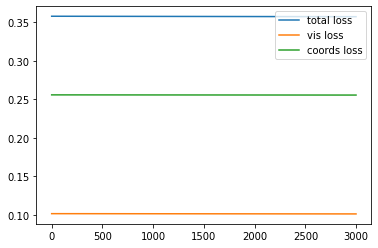

203
136


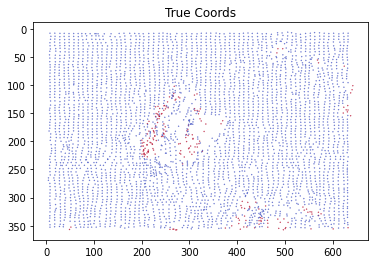

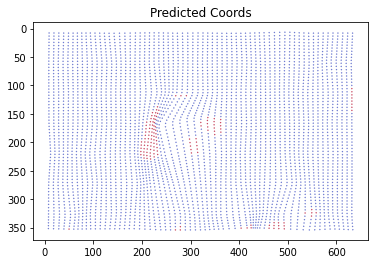

Training complete in 20m 55s
Train loss: 0.357005



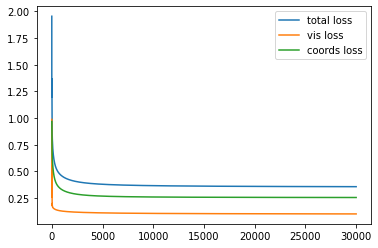

203
136


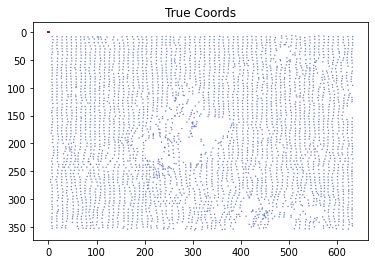

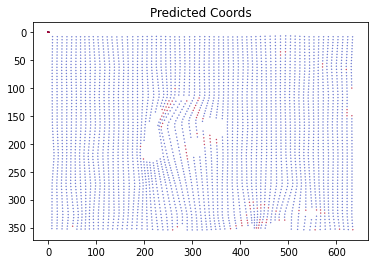

In [43]:
# set computation device
device = torch.device('cuda')

# initialise model
modified_model = initialise_model(device, to_learn=['backbone.conv1.weight', 'backbone.layer1.0.conv1.weight', 'classifier.4.weight', 'classifier.4.bias'])

# see what parameters will be tuned
params_to_update = modified_model.parameters()

print('Params to learn:')
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

# Define parameters
validation_split = .0
shuffle_dataset = True
random_seed = 42
batch_size = len(dataset)
num_epochs = 30_000

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
my_optimizer = optim.SGD(params_to_update, lr=0.101, momentum=0.9)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# Train and evaluate
modified_model, hist = train_model(modified_model,
                                   dataloaders_dict,
                                   my_criterion,
                                   my_vis_criterion,
                                   my_optimizer,
                                   num_epochs=num_epochs,
                                   verbose=True)

# Fine-tuning all layers

In [ ]:
# set computation device
device = torch.device('cuda')

# initialise model
modified_model = initialise_model(device, to_learn=['all'])

# see what parameters will be tuned
params_to_update = modified_model.parameters()
print('Params to learn:')
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

# Define parameters
validation_split = .0
shuffle_dataset = True
random_seed = 42
batch_size = len(dataset)
num_epochs = 30_000

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
my_optimizer = optim.SGD(params_to_update, lr=0.101, momentum=0.9)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# Train and evaluate
modified_model, hist = train_model(modified_model,
                                   dataloaders_dict,
                                   my_criterion,
                                   my_vis_criterion,
                                   my_optimizer,
                                   num_epochs=num_epochs,
                                   verbose=True)